In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import os
import numpy as np
import cv2
# Initialize a list to store the models
models = []
# Assuming that data_dir is the directory where your data is stored
data_dir = '../work/training'  # replace with the path to your data

# Get the list of all the images
image_paths = []
labels = []
for class_dir in os.listdir(data_dir):
    class_dir_path = os.path.join(data_dir, class_dir)
    for image_path in os.listdir(class_dir_path):
        image_paths.append(os.path.join(class_dir_path, image_path))
        labels.append(class_dir)

# Convert labels to integers
unique_labels = np.unique(labels)
label_dict = {label: i for i, label in enumerate(unique_labels)}
labels = np.array([label_dict[label] for label in labels])

# One-hot encode labels
labels = to_categorical(labels)

# Convert one-hot encoded labels to single labels
labels_single = np.argmax(labels, axis=1)

# Initialize a list to store the history of each fold
histories = []

# Perform k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize a list to store the predictions and actual labels of each fold
test_preds_all = []
test_labels_all = []

for train, test in kfold.split(image_paths, labels_single):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Load and preprocess the training images
    train_images = np.array([cv2.resize(cv2.imread(path), (150, 150)) for path in np.array(image_paths)[train]])
    train_images = train_images / 255.0
    train_labels = labels[train]

    # Load and preprocess the test images
    test_images = np.array([cv2.resize(cv2.imread(path), (150, 150)) for path in np.array(image_paths)[test]])
    test_images = test_images / 255.0
    test_labels = labels[test]

    history = model.fit(train_images, train_labels, epochs=25, validation_data=(test_images, test_labels))
    histories.append(history.history)
    # Use the model to predict the test set
    test_preds = model.predict(test_images)
    # Use the model to predict the test set
    test_preds = model.predict(test_images)
    # Store the predictions and actual labels in the lists
    test_preds_all.append(test_preds)
    test_labels_all.append(test_labels)
        # Save the model in the list
    models.append(model)
# Calculate the average accuracy and loss at each epoch
avg_acc = np.mean([x['accuracy'] for x in histories], axis=0)
avg_val_acc = np.mean([x['val_accuracy'] for x in histories], axis=0)
avg_loss = np.mean([x['loss'] for x in histories], axis=0)
avg_val_loss = np.mean([x['val_loss'] for x in histories], axis=0)





Epoch 1/25


30/30 [==============================] - 3s 73ms/step - loss: 1.7246 - accuracy: 0.3323 - val_loss: 1.3095 - val_accuracy: 0.3750
Epoch 2/25
30/30 [==============================] - 2s 59ms/step - loss: 1.2991 - accuracy: 0.3427 - val_loss: 1.2353 - val_accuracy: 0.4125
Epoch 3/25
30/30 [==============================] - 2s 55ms/step - loss: 1.2881 - accuracy: 0.3448 - val_loss: 1.2099 - val_accuracy: 0.4000
Epoch 4/25
30/30 [==============================] - 2s 51ms/step - loss: 1.2756 - accuracy: 0.3635 - val_loss: 1.1992 - val_accuracy: 0.4500
Epoch 5/25
30/30 [==============================] - 2s 53ms/step - loss: 1.2342 - accuracy: 0.3802 - val_loss: 1.1746 - val_accuracy: 0.5083
Epoch 6/25
30/30 [==============================] - 2s 57ms/step - loss: 1.1975 - accuracy: 0.4292 - val_loss: 1.1663 - val_accuracy: 0.4958
Epoch 7/25
30/30 [==============================] - 2s 53ms/step - loss: 1.1978 - accuracy: 0.4396 - val_loss: 1.1426 - val_accuracy: 0.5125
Epoch 8/

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
from tensorflow.keras.utils import to_categorical

In [5]:
test_labels_single = np.argmax(test_labels, axis=1)
test_preds_single = np.argmax(test_preds, axis=1)
# Calculate precision and recall
precision = precision_score(test_labels_single, test_preds_single, average='macro', zero_division=1)
recall = recall_score(test_labels_single, test_preds_single, average='macro', zero_division=1)

print(f'Precision: {precision}')
print(f'Recall: {recall}')


Precision: 0.5064836279339322
Recall: 0.35


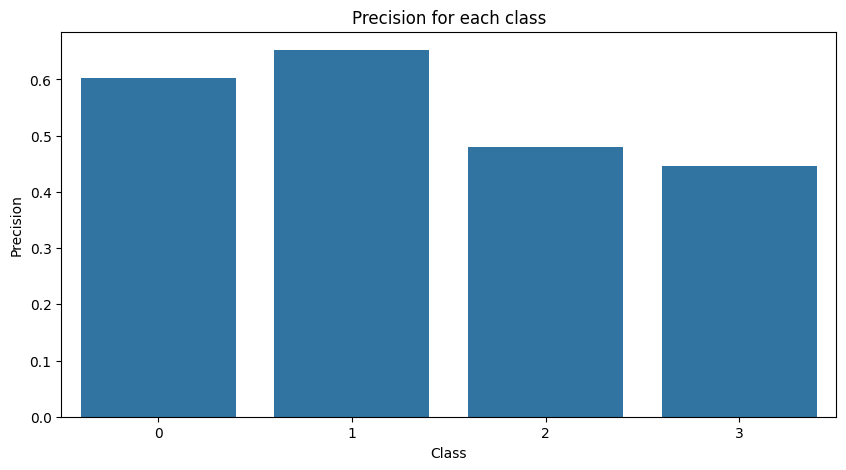

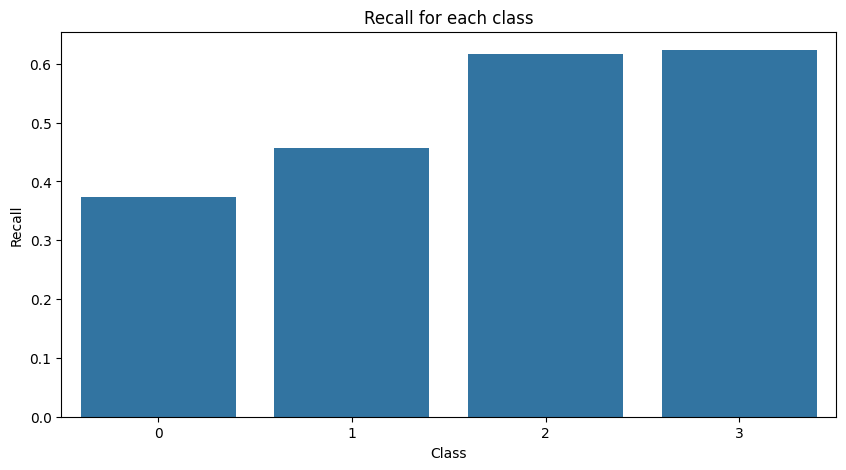

In [6]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the predictions and actual labels to single labels
test_preds_single = [np.argmax(pred) for preds in test_preds_all for pred in preds]
test_labels_single = [np.argmax(label) for labels in test_labels_all for label in labels]

# Get the classification report
report = classification_report(test_labels_single, test_preds_single, output_dict=True)

# Get precision and recall values
precision_values = [report[str(i)]['precision'] for i in range(4)]  # replace 4 with your number of classes
recall_values = [report[str(i)]['recall'] for i in range(4)]  # replace 4 with your number of classes

# Plot precision values
plt.figure(figsize=(10, 5))
sns.barplot(x=[str(i) for i in range(4)], y=precision_values)  # replace 4 with your number of classes
plt.title('Precision for each class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.show()

# Plot recall values
plt.figure(figsize=(10, 5))
sns.barplot(x=[str(i) for i in range(4)], y=recall_values)  # replace 4 with your number of classes
plt.title('Recall for each class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.show()

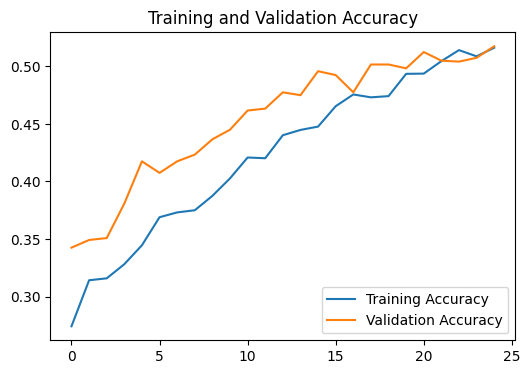

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(avg_acc, label='Training Accuracy')
plt.plot(avg_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

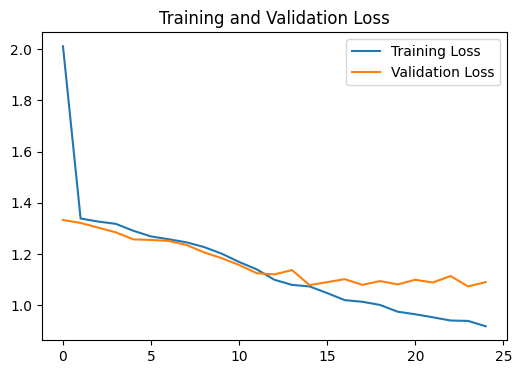

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(avg_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
cm = confusion_matrix(test_labels_single, test_preds_single)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[112  39  77  72]
 [ 45 137  45  73]
 [ 15  13 185  87]
 [ 14  21  78 187]]


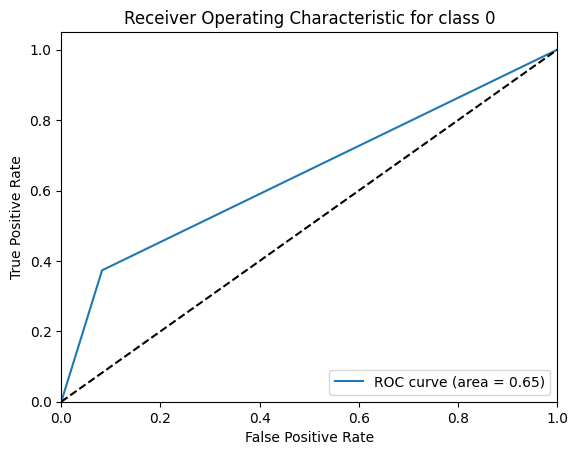

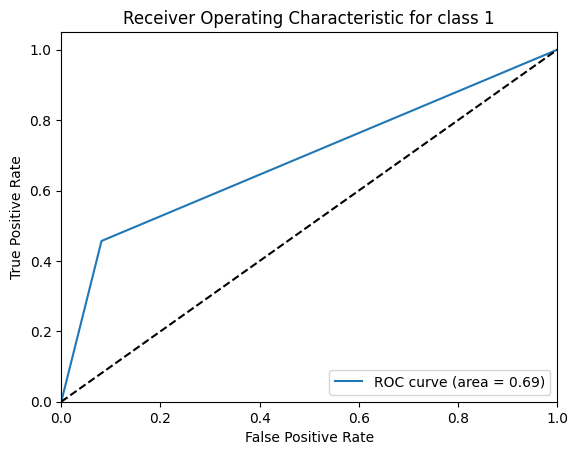

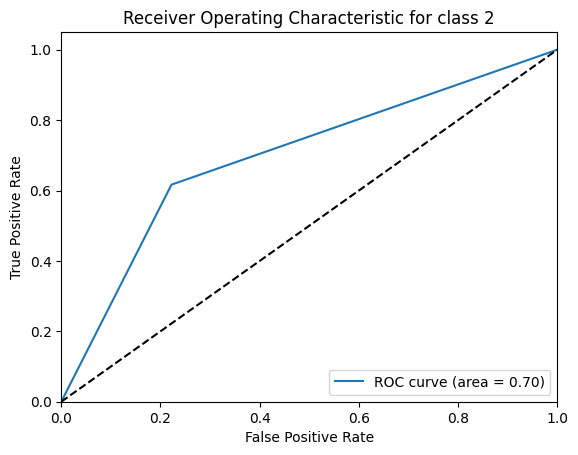

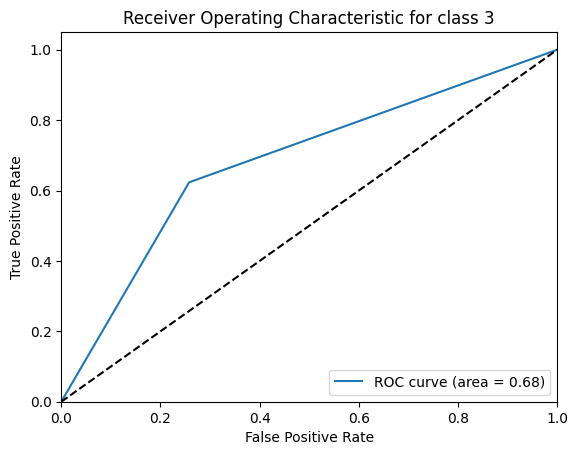

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Convert the predictions and actual labels to binary matrix
num_classes = len(np.unique(test_labels_single))  # get the number of unique classes
test_preds_bin = to_categorical(test_preds_single, num_classes=num_classes)
test_labels_bin = to_categorical(test_labels_single, num_classes=num_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

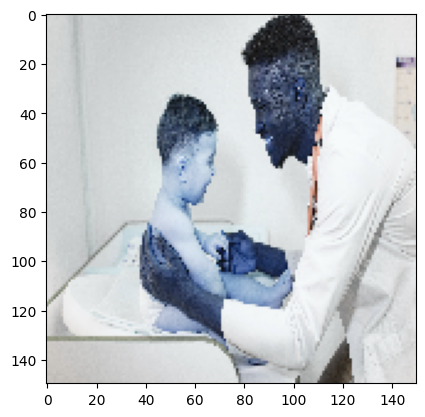

1/1 [==============================] - 0s 27ms/step
The predicted label for ../work/test5.jpg by model 1 is neither.
The predicted label for ../work/test5.jpg by model 2 is smoke.
The predicted label for ../work/test5.jpg by model 3 is neither.
The predicted label for ../work/test5.jpg by model 4 is neither.
The predicted label for ../work/test5.jpg by model 5 is neither.
The most common predicted label for ../work/test5.jpg by all models is neither.


In [14]:
predict_image_path = '../work/test5.jpg'  # replace with the path to your image

# Load and preprocess the image
predict_image = cv2.resize(cv2.imread(predict_image_path), (150, 150))
predict_image = predict_image / 255.0

# Display the image
plt.imshow(predict_image)
plt.show()

# Add an extra dimension for the batch size
predict_image = np.expand_dims(predict_image, axis=0)

# Initialize a list to store the predictions from all models
all_predictions = []

for model in models:  # assuming models is a list of your trained models
    # Predict the class
    predictions = model.predict(predict_image)
    # Convert prediction to label
    predicted_label = np.argmax(predictions, axis=1)
    predicted_label = unique_labels[predicted_label[0]]
    all_predictions.append(predicted_label)

# Get the most common prediction among all models
from collections import Counter
most_common_prediction = Counter(all_predictions).most_common(1)[0][0]
for i, predicted_label in enumerate(all_predictions):
    print(f'The predicted label for {predict_image_path} by model {i+1} is {predicted_label}.')
print(f'The most common predicted label for {predict_image_path} by all models is {most_common_prediction}.')
